In [1]:
import pandas as pd
import numpy as np

In [2]:
# Load the CSV file
df = pd.read_csv("Truth_Seeker_Model_Dataset.csv")
df.head()

,Unnamed: 0,author,statement,target,BinaryNumTarget,manual_keywords,tweet,5_label_majority_answer,3_label_majority_answer
0,0,D.L. Davis,End of eviction moratorium means millions of A...,True,1,"Americans, eviction moratorium",@POTUS Biden Blunders - 6 Month Update\n\nInfl...,Mostly Agree,Agree
1,1,D.L. Davis,End of eviction moratorium means millions of A...,True,1,"Americans, eviction moratorium",@S0SickRick @Stairmaster_ @6d6f636869 Not as m...,NO MAJORITY,Agree
2,2,D.L. Davis,End of eviction moratorium means millions of A...,True,1,"Americans, eviction moratorium",THE SUPREME COURT is siding with super rich pr...,Agree,Agree
3,3,D.L. Davis,End of eviction moratorium means millions of A...,True,1,"Americans, eviction moratorium",@POTUS Biden Blunders\n\nBroken campaign promi...,Mostly Agree,Agree
4,4,D.L. Davis,End of eviction moratorium means millions of A...,True,1,"Americans, eviction moratorium",@OhComfy I agree. The confluence of events rig...,Agree,Agree


In [5]:
# Data cleaning
# Drop unnecessary column
df_cleaned = df.drop(columns=["Unnamed: 0"])
missing_values = df_cleaned.isnull().sum()
# Check for duplicates
duplicates_count = df_cleaned.duplicated().sum()
# Drop duplicates if any
df_cleaned = df_cleaned.drop_duplicates()
# Save the cleaned dataset
df_cleaned.to_csv("cleaned_truth_seeker_dataset.csv", index=False)
print("Missing Values:\n", missing_values)
print(f"Duplicate Rows Removed: {duplicates_count}")
print("Final Shape:", df_cleaned.shape)

Missing Values:
 author                     0
statement                  0
target                     0
BinaryNumTarget            0
manual_keywords            0
tweet                      0
5_label_majority_answer    0
3_label_majority_answer    0
dtype: int64
Duplicate Rows Removed: 0
Final Shape: (134198, 8)


In [7]:
# Upload Cleaned Data to PostgreSQL
import psycopg2
from sqlalchemy import create_engine

In [55]:
# Database connection settings
db_user = "postgres"
db_password = "lasc"
db_host = "localhost"
db_port = "5432"
db_name = "fake_tweet_db"

# Create connection string and engine
engine = create_engine(f"postgresql+psycopg2://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}")

In [189]:
table_name = "truth_seeker_news"
# Upload data to PostgreSQL
df_cleaned.to_sql(table_name, engine, if_exists='replace', index=False)
print("✅ Data successfully uploaded to PostgreSQL!")

✅ Data successfully uploaded to PostgreSQL!


In [11]:
# ETL Pipeline for News Data (Text-Based)
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
import re
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
# nltk.download('punkt')         # Sentence & word tokenizer
# nltk.download('stopwords') 

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/olamideabioro/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
# Extract: Read from PostgreSQL
df = pd.read_sql("SELECT * FROM truth_seeker_news", engine)
df.head()

,author,statement,target,BinaryNumTarget,manual_keywords,tweet,5_label_majority_answer,3_label_majority_answer
0,D.L. Davis,End of eviction moratorium means millions of A...,True,1,"Americans, eviction moratorium",@POTUS Biden Blunders - 6 Month Update\n\nInfl...,Mostly Agree,Agree
1,D.L. Davis,End of eviction moratorium means millions of A...,True,1,"Americans, eviction moratorium",@S0SickRick @Stairmaster_ @6d6f636869 Not as m...,NO MAJORITY,Agree
2,D.L. Davis,End of eviction moratorium means millions of A...,True,1,"Americans, eviction moratorium",THE SUPREME COURT is siding with super rich pr...,Agree,Agree
3,D.L. Davis,End of eviction moratorium means millions of A...,True,1,"Americans, eviction moratorium",@POTUS Biden Blunders\n\nBroken campaign promi...,Mostly Agree,Agree
4,D.L. Davis,End of eviction moratorium means millions of A...,True,1,"Americans, eviction moratorium",@OhComfy I agree. The confluence of events rig...,Agree,Agree


In [15]:
# Transform: Preprocessing function
def simple_clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)  # remove punctuation and numbers
    tokens = text.split()
    tokens = [w for w in tokens if w not in stop_words]
    return ' '.join(tokens)

df['clean_statement'] = df['statement'].apply(simple_clean_text)

In [17]:
# Feature Extraction: TF-IDF vectorization
# Term Frequency (TF): How often a word appears in a document.
# Example: If “covid” appears 3 times in a tweet with 10 words, TF = 3/10 = 0.3

# Inverse Document Frequency (IDF): Measures how unique or rare a word is across all documents.
# Common words like “the”, "of" and so on appear in many documents, so their IDF is low.
# Rare words like “eviction” appear in fewer documents, so IDF is high.

tfidf = TfidfVectorizer(max_features=500)
X_tfidf = tfidf.fit_transform(df['clean_statement'])

In [19]:
# Convert to DataFrame
df_tfidf = pd.DataFrame(X_tfidf.toarray(), columns=tfidf.get_feature_names_out())

In [ ]:
# Load: Save the transformed features to PostgreSQL
df_tfidf.to_sql("transformed_truth_news", engine, if_exists='replace', index=False)

print("✅ ETL completed: Transformed features saved to 'transformed_truth_news' in PostgreSQL.")

In [21]:
# Programmatic Analysis and Visualization
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

In [23]:
df_tfidf.head()

,abortion,abortions,absentee,according,act,actually,administration,afghanistan,african,africanamerican,...,worked,worker,workers,world,would,year,years,yet,york,young
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
df_tfidf['target'] = df['BinaryNumTarget'].values
print(df_tfidf.columns)

Index(['abortion', 'abortions', 'absentee', 'according', 'act', 'actually',
       'administration', 'afghanistan', 'african', 'africanamerican',
       ...
       'worker', 'workers', 'world', 'would', 'year', 'years', 'yet', 'york',
       'young', 'target'],
      dtype='object', length=501)


In [27]:
# Features (from TF-IDF) and target
X = df_tfidf.drop("target", axis=1)
y = df_tfidf["target"]

In [29]:
# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
# Train model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [32]:
# Predict and evaluate
y_pred = model.predict(X_test)

In [35]:
# Metrics
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     13075
           1       1.00      1.00      1.00     13765

    accuracy                           1.00     26840
   macro avg       1.00      1.00      1.00     26840
weighted avg       1.00      1.00      1.00     26840

Accuracy Score: 0.9983606557377049


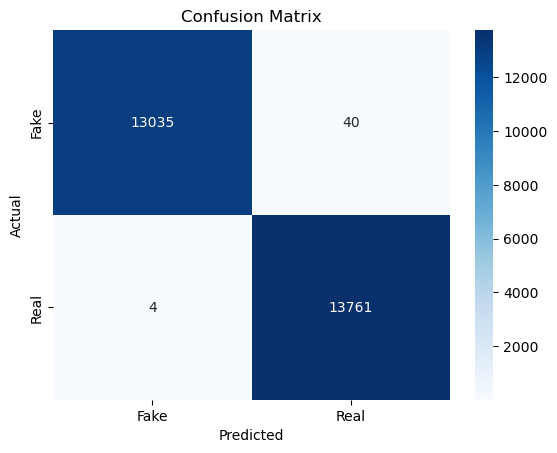

In [37]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [39]:
# Visualize Feature Importances
# Get feature importances
importances = model.feature_importances_
feature_names = X.columns

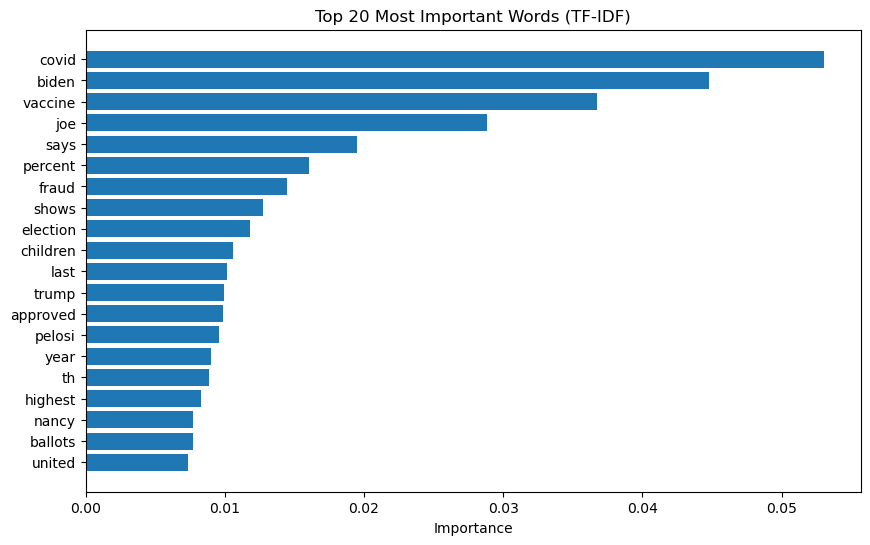

In [41]:
# Top 20 keywords
indices = np.argsort(importances)[-20:]
plt.figure(figsize=(10,6))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.title("Top 20 Most Important Words (TF-IDF)")
plt.xlabel("Importance")
plt.show()

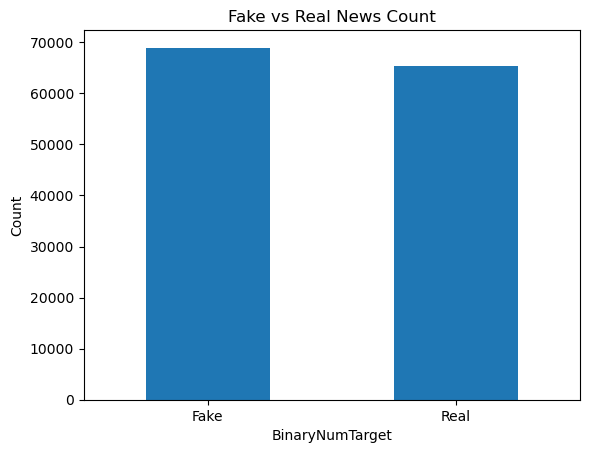

In [43]:
# Label Distribution Visualization
df['BinaryNumTarget'].value_counts().plot(kind='bar', title="Fake vs Real News Count")
plt.xticks(ticks=[0,1], labels=["Fake", "Real"], rotation=0)
plt.ylabel("Count")
plt.show()

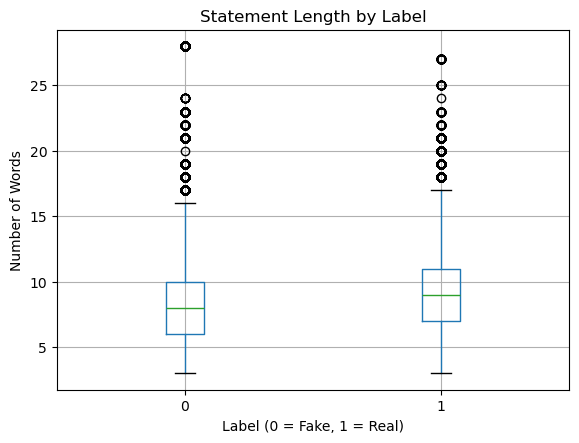

In [45]:
# Check if fake news tends to be shorter or longer.
df['statement_length'] = df['clean_statement'].apply(lambda x: len(x.split()))

df.boxplot(column='statement_length', by='BinaryNumTarget')
plt.title('Statement Length by Label')
plt.suptitle('')
plt.xlabel('Label (0 = Fake, 1 = Real)')
plt.ylabel('Number of Words')
plt.show()

Top Keywords in Real News: [('Trump', 5115), ('Obama', 2670), ('minimum wage', 2290), ('marijuana', 2079), ('Americans', 1998), ('Texas', 1742), ('background checks', 1210), ('United States', 1139), ('racism', 995), ('California', 875)]
Top Keywords in Fake News: [('Biden', 7888), ('vaccine', 4981), ('children', 2079), ('Michigan', 1957), ('Harris', 1228), ('Trump', 1198), ('ballots', 1120), ('hydroxychloroquine', 1118), ('Pelosi', 1097), ('Joe Biden', 1062)]


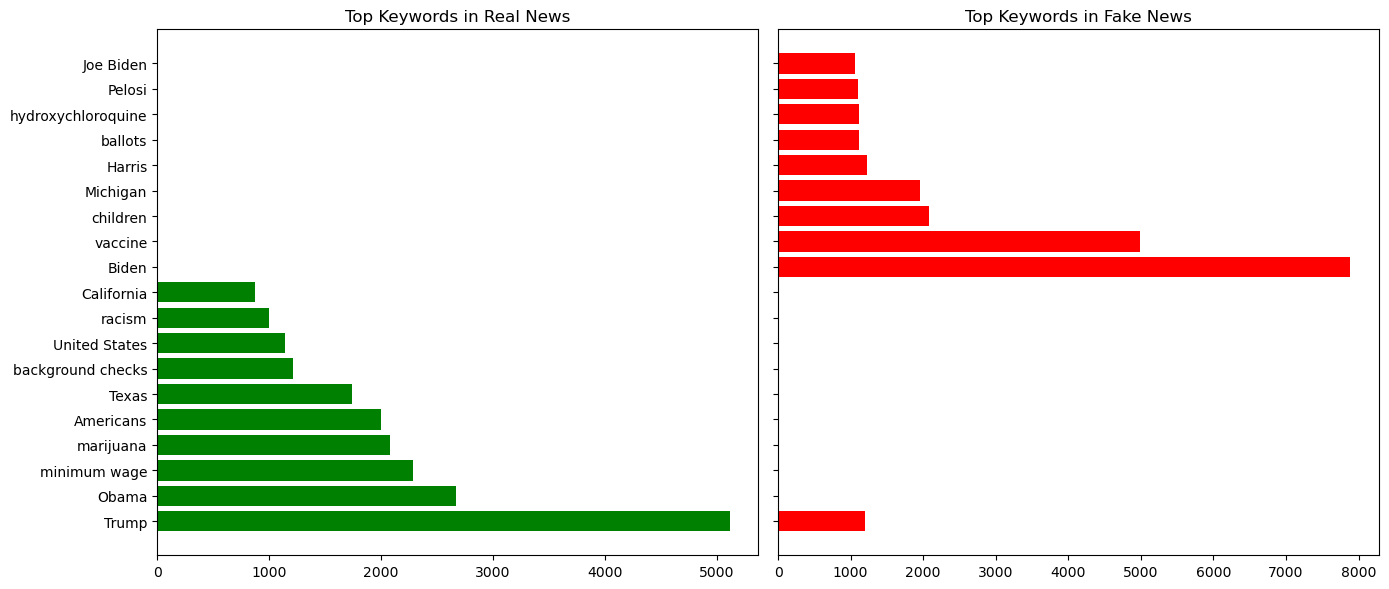

In [47]:
# Examine manual_keywords column.
from collections import Counter

# Convert manual_keywords string into list
df['keyword_list'] = df['manual_keywords'].str.split(',')

# Separate and explode keyword lists by class
real_keywords = df[df['BinaryNumTarget'] == 1]['keyword_list'].explode().str.strip()
fake_keywords = df[df['BinaryNumTarget'] == 0]['keyword_list'].explode().str.strip()

# Get most common keywords
real_common = Counter(real_keywords).most_common(10)
fake_common = Counter(fake_keywords).most_common(10)

# Print top keywords for context
print("Top Keywords in Real News:", real_common)
print("Top Keywords in Fake News:", fake_common)

# Convert to DataFrames for plotting
real_df = pd.DataFrame(real_common, columns=["Keyword", "Frequency"])
fake_df = pd.DataFrame(fake_common, columns=["Keyword", "Frequency"])

# Plot side-by-side horizontal bar charts
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

axes[0].barh(real_df["Keyword"], real_df["Frequency"], color="green")
axes[0].set_title("Top Keywords in Real News")
axes[0].invert_yaxis()

axes[1].barh(fake_df["Keyword"], fake_df["Frequency"], color="red")
axes[1].set_title("Top Keywords in Fake News")
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

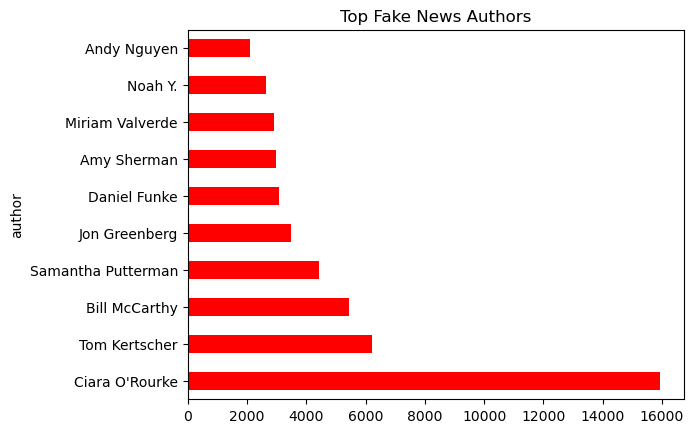

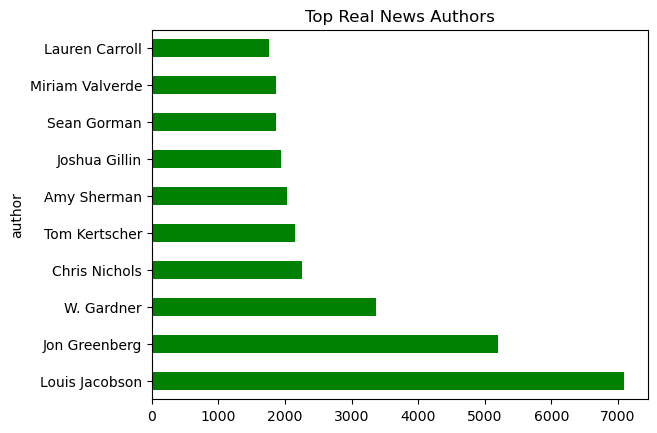

In [49]:
# Top authors by class
fake_authors = df[df['BinaryNumTarget'] == 0]['author'].value_counts().head(10)
real_authors = df[df['BinaryNumTarget'] == 1]['author'].value_counts().head(10)

fake_authors.plot(kind='barh', title="Top Fake News Authors", color='red')
plt.show()

real_authors.plot(kind='barh', title="Top Real News Authors", color='green')
plt.show()

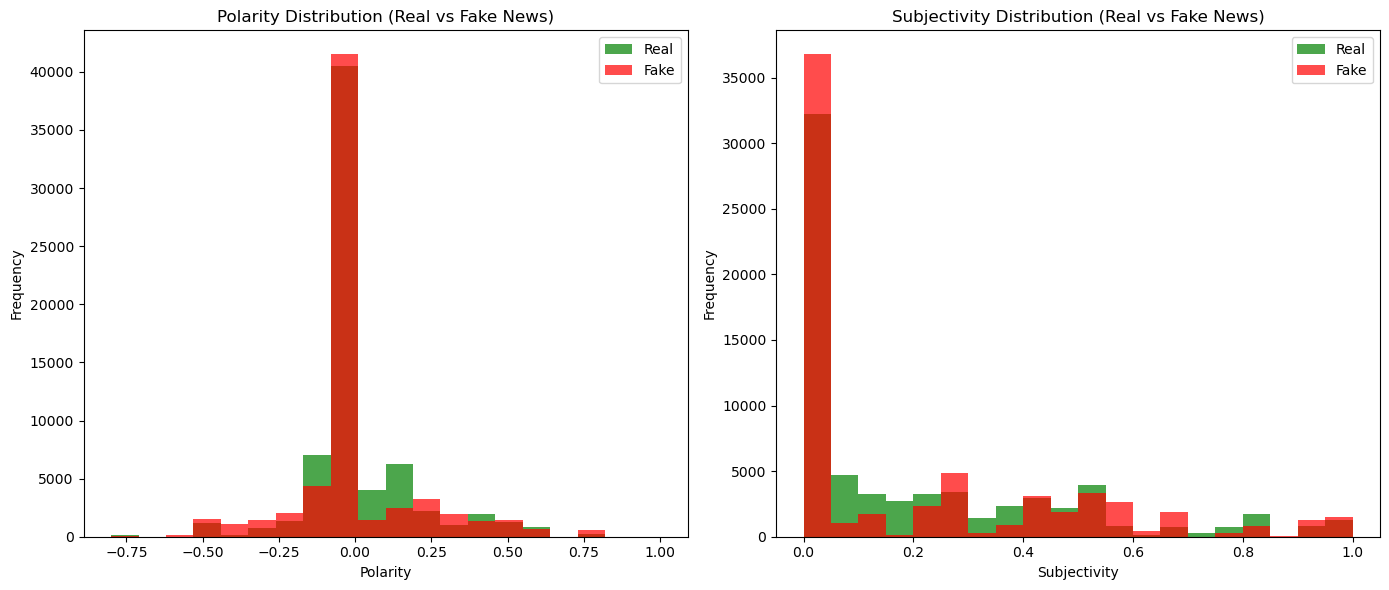

In [51]:
# Sentiment Analysis per Class
# Polarity: Is the text positive, neutral, or negative?
# Ranges from -1 (very negative) to +1 (very positive)
# Subjectivity: Is the text more factual or opinionated?
# Ranges from 0 (very objective) to 1 (very subjective)

from textblob import TextBlob

# Function to extract polarity and subjectivity
def get_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity, blob.sentiment.subjectivity

# Apply sentiment function
df['polarity'], df['subjectivity'] = zip(*df['clean_statement'].apply(get_sentiment))

# Sentiment analysis per class
real_sentiment = df[df['BinaryNumTarget'] == 1][['polarity', 'subjectivity']]
fake_sentiment = df[df['BinaryNumTarget'] == 0][['polarity', 'subjectivity']]

# Plot sentiment comparison for Real and Fake News
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Polarity
axes[0].hist(real_sentiment['polarity'], bins=20, alpha=0.7, label='Real', color='green')
axes[0].hist(fake_sentiment['polarity'], bins=20, alpha=0.7, label='Fake', color='red')
axes[0].set_title("Polarity Distribution (Real vs Fake News)")
axes[0].set_xlabel("Polarity")
axes[0].set_ylabel("Frequency")
axes[0].legend()

# Subjectivity
axes[1].hist(real_sentiment['subjectivity'], bins=20, alpha=0.7, label='Real', color='green')
axes[1].hist(fake_sentiment['subjectivity'], bins=20, alpha=0.7, label='Fake', color='red')
axes[1].set_title("Subjectivity Distribution (Real vs Fake News)")
axes[1].set_xlabel("Subjectivity")
axes[1].set_ylabel("Frequency")
axes[1].legend()

plt.tight_layout()
plt.show()
